# Modeling

## Import Libraries and the final salary data set

In [1]:
import time
import nltk
from nltk.corpus import stopwords

from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.collocations import *
import string, re

from gensim.models import Word2Vec

from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)

In [2]:
salary_df = pd.read_csv("salary_final.csv")

In [3]:
salary_df.head()

,Unnamed: 0,Title,Company,Link,Review,Salary,Description,Location2,Rate_by,low,high,min,max,adjusted_salary,adjusted_yearly_salary
0,2,"2021048 Data Scientist $215,000.00",B4CORP,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,None,"Up to $215,000 a year",Position Requires a Top Secret (TS/SCI) Cleara...,"Arlington, VA",Yearly,"Up to $215,000 a year",NaN,215000.0,0.0,215000.0,215000.0
1,6,Data Science/Data Analyst,CRAiC LLC,https://www.indeed.com/company/CRAiC-LLC/jobs/...,None,"$60,000 a year",Cost Readiness Analytics (CRAiC LLC) is lookin...,"Arlington, VA",Yearly,"$60,000 a year",NaN,60000.0,0.0,60000.0,60000.0
2,8,Data Science Intern,MilliporeSigma,https://www.indeed.com/company/Serono/jobs/Dat...,3.9,$20 - $25 an hour,Job Title: Data Science Intern\rA career with ...,"Arlington, VA",Hourly,$20,$25 an hour,20.0,25.0,22.5,46800.0
3,11,Jr. Data Scientist,Numero Data LLC,https://www.indeed.com/company/Numero-Data-LLC...,None,"$70,000 - $85,000 a year",Ideal candidate should have a degree in a quan...,"Arlington, VA",Yearly,"$70,000","$85,000 a year",70000.0,85000.0,77500.0,77500.0
4,16,Business Data Quality Engineer,HRU Technical Resources,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,None,$45 - $55 an hour,Please note that this is not a corp to corp or...,"Arlington, VA",Hourly,$45,$55 an hour,45.0,55.0,50.0,104000.0


In [4]:
salary_df.groupby('Location2')['adjusted_yearly_salary'].count()

Location2
Arlington, VA          45
Atlanta, GA            49
Austin, TX             39
Boston, MA             60
Cambridge, MA          12
Charlotte, NC          56
Chicago, IL            40
Dallas, TX             21
Denver, CO             39
Hartford, CT           46
Houston, TX             8
Irving, TX              1
Los Angeles, CA        96
Miami, FL              19
New York, NY           77
Palo Alto, CA          12
Philadelphia, PA       39
Pittsburg, PA           4
Portland, OR           45
Raleigh-Durham, NC      3
San Antonio, TX         1
San Francisco, CA     128
San Jose, CA           41
Seattle, WA            67
Washington, DC         10
Name: adjusted_yearly_salary, dtype: int64

In [5]:
def clean_word(job_descriptions):
    jd_data=[]
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    stopwords_list = stopwords.words('english')
    stopwords_list += list(string.punctuation)
    stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    
    for jd in job_descriptions:
        jd_tokens_raw = nltk.regexp_tokenize(jd, pattern)
        jd_tokens=[word.lower() for word in jd_tokens_raw]
        jd_words_stopped = [word for word in jd_tokens if word not in stopwords_list]
        jd_data.append(jd_words_stopped)
    return pd.Series(jd_data) # Turn list of lists to series of lists to use in Word2Vec

In [6]:
#Combine Title with the Description
salary_df['combined_text'] = salary_df['Title'].str.cat(salary_df['Description'], sep = ' ')

## Model 1:  Use Word2Vec Model 

We are going to use Word2Vec model in this section. Word2vec is a group of related models that are used to produce word embeddings. These models are shallow, two-layer neural networks that are trained to reconstruct linguistic contexts of words. Word2vec takes as its input a large corpus of text and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space. Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located close to one another in the space.

We need to specify following parameter to the model:
* the `size` of the word vectors we want to learn 
* the `window` size to use when training the model
* `min_count`, which corresponds to the minimum number of times a word must be used in the corpus in order to be included in the training (for instance, `min_count=5` would only learn word embeddings for words that appear 5 or more times throughout the entire training set)
* `workers`, the number of threads to use for training, which can speed up processing (`4` is typically used, since most processors nowadays have at least 4 cores)

In [7]:
data = clean_word(salary_df['combined_text'])
target = salary_df['adjusted_yearly_salary']

In [8]:
data[0]

['data',
 'scientist',
 'position',
 'requires',
 'top',
 'secret',
 'ts',
 'sci',
 'clearance',
 'polygraph',
 'estimated',
 'salary',
 'position',
 'level',
 'level',
 'subject',
 'matter',
 'expert',
 'salary',
 'range',
 'per',
 'year',
 'b',
 'corp',
 'estimated',
 'salary',
 'ranges',
 'position',
 'level',
 'min',
 'salary',
 'max',
 'salary',
 'level',
 'subject',
 'matter',
 'expert',
 'level',
 'expert',
 'level',
 'senior',
 'level',
 'full',
 'performance',
 'mandatory',
 'requirements',
 'java',
 'development',
 'experience',
 'production',
 'environment',
 'required',
 'software',
 'developer',
 'list',
 'years',
 'experience',
 'demonstrated',
 'job',
 'experience',
 'troubleshooting',
 'user',
 'issues',
 'list',
 'years',
 'experience',
 'demonstrated',
 'job',
 'experience',
 'writing',
 'system',
 'automation',
 'scripts',
 'linux',
 'environment',
 'using',
 'tools',
 'bash',
 'sh',
 'python',
 'ruby',
 'perl',
 'list',
 'years',
 'experience',
 'demonstrated',
 'jo

### Random Forest Regressor,  Linear SVC and Linear Regression in the pipeline

http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/
TF-IDF embedding, focus on important words.


https://scikit-learn.org/stable/modules/classes.html
#module-sklearn.feature_extraction.text
https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html

#### Word2Vec Model from scratch

In [28]:
model = Word2Vec(data,
                size=500,
                window=5,
                min_count=2,
                workers=4)

In [29]:
model.train(data,total_examples=model.corpus_count, epochs=10)

(3251037, 3482870)

In [30]:
wv = model.wv

In [ ]:
wv.vector_size

In [31]:
wv.most_similar('engineer')

[('architect', 0.7793104648590088),
 ('sr', 0.7628631591796875),
 ('scientist', 0.7366271018981934),
 ('developer', 0.7239082455635071),
 ('administrator', 0.7036694884300232),
 ('dba', 0.6981167793273926),
 ('principal', 0.6844441890716553),
 ('competitively', 0.66315096616745),
 ('iot', 0.6516892910003662),
 ('ii', 0.639428973197937)]

To be able to use in a pipeline, need fit and transform

In [32]:
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


In [33]:
len(w2v.values())

9077

Averaging word vectors for all words in a text.

In [34]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.values())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [35]:
#Use pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

rf =  Pipeline([('Word2Vec Vectorizer', MeanEmbeddingVectorizer(w2v)),
              ('Random Forest', RandomForestRegressor(n_estimators=100, verbose=True, n_jobs=3))])
svr = Pipeline([('Word2Vec Vectorizer', MeanEmbeddingVectorizer(w2v)),
              ('SVR-lin', SVR(kernel='rbf', C=0.5))])
                
#lr = Pipeline([('Word2Vec Vectorizer', MeanEmbeddingVectorizer(w2v)),
              #('Linear Regression', LinearRegression(n_jobs=3))])

In [42]:
models = [('Random Forest', rf),
          ('SVR-lin', svr)]
          #('Linear Regression', lr)]

In [43]:
scores = [(name, cross_val_score(model, data, target, cv=2).mean()) for name, model, in models]

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    3.3s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    5.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  82 tasks      | elapsed:    3.8s
[Parallel(n_jobs=3)]: Done  95 out of 100 | elapsed:    4.3s remaining:    0.2s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    4.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished


TD-IDF Embedding

In [ ]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.values())

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [ ]:
#Use pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

rf =  Pipeline([('Word2Vec Vectorizer', TfidfEmbeddingVectorizer(w2v)),
              ('Random Forest', RandomForestRegressor(n_estimators=100, verbose=True, n_jobs=3))])
svr = Pipeline([('Word2Vec Vectorizer', TfidfEmbeddingVectorizer(w2v)),
              ('SVR-lin', SVR(kernel='rbf'))])
                
#lr = Pipeline([('Word2Vec Vectorizer', MeanEmbeddingVectorizer(w2v)),
              #('Linear Regression', LinearRegression(n_jobs=3))])

In [ ]:
models = [('Random Forest', rf),
          ('SVR-lin', svc)]
          #('Linear Regression', lr)]

In [ ]:
scores = [(name, cross_val_score(model, data, target, cv=2).mean()) for name, model, in models]

In [ ]:
scores

### Use Pretrained GloVe Model

#### Getting the Total Vocabulary

In [24]:
total_vocabulary = set(word for jd in data for word in jd)

In [25]:
len(total_vocabulary)
print('There are {} unique tokens in the dataset.'.format(len(total_vocabulary)))

There are 13283 unique tokens in the dataset.


In [26]:
#Get the appropriate vectors out of the GloVe file
glove = {}
with open('glove_6B_50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [18]:
glove['data']

array([ 5.3101e-01, -5.5869e-01,  1.7674e+00,  4.4824e-01,  2.2341e-01,
       -3.4559e-01, -7.7679e-01, -9.6117e-01,  1.1669e+00,  7.4279e-02,
        8.1470e-01, -5.9428e-02,  6.4599e-02,  1.5176e-03,  9.9179e-02,
        3.6602e-01, -9.8724e-01, -8.3913e-01,  1.5917e-01, -7.7603e-01,
        7.3474e-01, -6.4861e-01,  4.6174e-01,  8.8162e-03,  5.1738e-01,
       -6.5976e-01, -7.4010e-01, -1.3928e-01,  8.1094e-02,  2.0657e-01,
        3.5652e+00, -8.2264e-01,  5.7360e-01, -1.7268e+00,  6.2356e-03,
        6.7672e-02, -2.3411e-01,  3.5163e-02,  2.6507e-01, -2.9966e-01,
        7.4323e-01, -4.5027e-01,  1.9406e-01,  4.8611e-01, -4.3075e-01,
       -2.5210e-01,  1.2774e+00,  1.5815e+00,  6.5838e-01, -2.0978e-01],
      dtype=float32)

In [ ]:
len(next(iter(glove)))

In [27]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

To be able to use in a pipeline, need fit and transform

### Use Random Forest Regressor and Linear Regression in the pipeline

http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/
TF-IDF embedding, focus on important words.

In [28]:
#Use pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

rf =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Random Forest', RandomForestRegressor(n_estimators=100, verbose=True, n_jobs=3))])
svr = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                ('Support Vector Machine', SVR(kernel='linear'))])
lr = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Linear Regression', LinearRegression())])

In [30]:
models = [('Random Forest', rf),
          ('Support Vector Machine', svr),
          ('Linear Regression', lr)]

In [31]:
scores = [(name, cross_val_score(model, data, target, cv=2).mean()) for name, model, in models]

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  89 tasks      | elapsed:    1.5s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished


In [32]:
scores

[('Random Forest', 0.23296344891439746),
 ('Support Vector Machine', -0.12380575212964273),
 ('Linear Regression', 0.21515161505580238)]

The score is pretty low. There is plenty of room to improve the model performance: standardize the scale of salary, add more parameters to the regression model.

## Model 2: Deep Learning Models with Word Embeddings

In [45]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.layers import Flatten

In [10]:
y = np.array(target)

In [12]:
y

array([215000. ,  60000. ,  46800. ,  77500. , 104000. , 130186. ,
       104000. ,  50294.4,  50000. ,  93832.5,  93600. ,  32400. ,
       125000. , 157500. ,  97015. , 182000. , 139512.5, 104521. ,
       125000. ,  12000. , 130000. ,  66320.8, 145000. , 125000. ,
       100000. , 135000. ,  45000. , 190000. , 215000. ,  48880. ,
       109200. ,  32400. , 122500. , 167500. ,  75000. , 125000. ,
       155000. , 140000. , 150000. , 105000. , 111009.5, 132500. ,
        32400. ,  94701.5,  88400. ,  39988. ,  26000. , 124800. ,
       115000. ,  67000. , 150800. , 125755.5,  65520. , 138743.5,
        50000. ,  60320. ,  72800. ,  62400. ,  72500. ,  44040. ,
        65000. ,  85000. ,  59800. ,  70000. , 175000. , 100000. ,
        90000. , 114400. ,  57500. ,  70000. ,  56671. ,  66000. ,
       112500. ,  78000. ,  65520. ,  62500. ,  70000. ,  90000. ,
        63440. ,  45000. ,  45000. ,  63000. ,  56475. ,  70000. ,
       105000. ,  65000. ,  61000. ,  93964. , 114400. , 15080

In [68]:
tokenizer = text.Tokenizer() #limit the number of words
tokenizer.num_words = 500
tokenizer.fit_on_texts(list(salary_df['combined_text']))
list_tokenized_jd = tokenizer.texts_to_sequences(salary_df['combined_text'])
X_t = sequence.pad_sequences(list_tokenized_jd, maxlen=100)

In [69]:
len(list_tokenized_jd)

963

In [70]:
X_t.shape

(963, 100)

#### Train-Test Split

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=0.1, random_state=4)

In [74]:
y_train.shape

(866,)

In [17]:
y_train.shape

(866,)

In [75]:
#Transform features by scaling each feature to a given range
from sklearn.preprocessing import MinMaxScaler

scalarX_train, scalarX_test, scalarY_train, scalarY_test = MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler()
scalarX_train.fit(X_train)
scalarY_train.fit(y_train.reshape(866,1))
scalarX_test.fit(X_test)
scalarY_test.fit(y_test.reshape(97,1))
X_train_new = scalarX_train.transform(X_train)
y_train_new = scalarY_train.transform(y_train.reshape(866,1))
X_test_new = scalarX_test.transform(X_test)
y_test_new = scalarY_test.transform(y_test.reshape(97,1))

In [76]:
X_train_new.shape

(866, 100)

In [77]:
y_train_new.shape

(866, 1)

In [78]:
model = Sequential()

embedding_size = 64
model.add(Embedding(100, embedding_size, input_length = 100 )) #try 100, 200, single LSTM and single dense 100
model.add(LSTM(128, return_sequences=True))
#model.add(LSTM(64))
#model.add(GlobalMaxPool1D())
#model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(32, activation='relu'))
model.add(Flatten())   #add Flatten layer 
model.add(Dense(1, activation='linear'))

In [79]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 100, 64)           6400      
_________________________________________________________________
lstm_10 (LSTM)               (None, 100, 128)          98816     
_________________________________________________________________
dense_24 (Dense)             (None, 100, 100)          12900     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 10001     
Total params: 128,117
Trainable params: 128,117
Non-trainable params: 0
_______________________________________________

In [80]:
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

In [81]:
model.fit(X_train_new, y_train_new, epochs=50, batch_size=32, validation_split=0.2)

Train on 692 samples, validate on 174 samples
Epoch 1/50
692/692 [==============================] - 3s 4ms/step - loss: 0.0272 - mse: 0.0272 - mae: 0.1285 - val_loss: 0.0181 - val_mse: 0.0181 - val_mae: 0.1068
Epoch 2/50
692/692 [==============================] - 2s 3ms/step - loss: 0.0213 - mse: 0.0213 - mae: 0.1140 - val_loss: 0.0185 - val_mse: 0.0185 - val_mae: 0.1013
Epoch 3/50
692/692 [==============================] - 2s 3ms/step - loss: 0.0226 - mse: 0.0226 - mae: 0.1161 - val_loss: 0.0172 - val_mse: 0.0172 - val_mae: 0.1009
Epoch 4/50
692/692 [==============================] - 2s 3ms/step - loss: 0.0214 - mse: 0.0214 - mae: 0.1143 - val_loss: 0.0179 - val_mse: 0.0179 - val_mae: 0.1061
Epoch 5/50
692/692 [==============================] - 2s 3ms/step - loss: 0.0223 - mse: 0.0223 - mae: 0.1150 - val_loss: 0.0193 - val_mse: 0.0193 - val_mae: 0.1125
Epoch 6/50
692/692 [==============================] - 2s 3ms/step - loss: 0.0225 - mse: 0.0225 - mae: 0.1168 - val_loss: 0.0172 - val_

692/692 [==============================] - 2s 3ms/step - loss: 0.0185 - mse: 0.0185 - mae: 0.1033 - val_loss: 0.0180 - val_mse: 0.0180 - val_mae: 0.1034


In [82]:
from sklearn.metrics import mean_squared_error, r2_score

In [83]:
def nn_model_evaluation(model, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    """
    For a given neural network model that has already been fit, prints for the train and tests sets the MSE and r squared
    values, a line graph of the loss in each epoch, and a scatterplot of predicted vs. actual values with a line
    representing where predicted = actual values. Optionally, a value for skip_epoch can be provided, which skips that
    number of epochs in the line graph of losses (useful in cases where the loss in the first epoch is orders of magnitude
    larger than subsequent epochs). Training and test sets can also optionally be specified.
    """

    # MSE and r squared values
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
    print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred),4))
    
    # Line graph of losses
    model_results = model.history.history
    plt.plot(list(range((skip_epochs+1),len(model_results['loss'])+1)), model_results['loss'][skip_epochs:], label='Train')
    plt.plot(list(range((skip_epochs+1),len(model_results['val_loss'])+1)), model_results['val_loss'][skip_epochs:], label='Test', color='green')
    plt.legend()
    plt.title('Training and test loss at each epoch', fontsize=14)
    plt.show()
    
    # Scatterplot of predicted vs. actual values
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
    plt.subplots_adjust(top=0.93, wspace=0)
    
    ax1.scatter(y_test, y_test_pred, s=2, alpha=0.7)
    ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax1.set_title('Test set')
    ax1.set_xlabel('Actual values')
    ax1.set_ylabel('Predicted values')
    
    ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
    ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax2.set_title('Train set')
    ax2.set_xlabel('Actual values')
    ax2.set_ylabel('')
    ax2.set_yticklabels(labels='')
    
    plt.show()

Training MSE: 0.0176
Validation MSE: 0.0548

Training r2: 0.1154
Validation r2: -0.5203


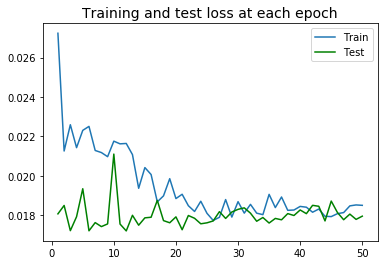

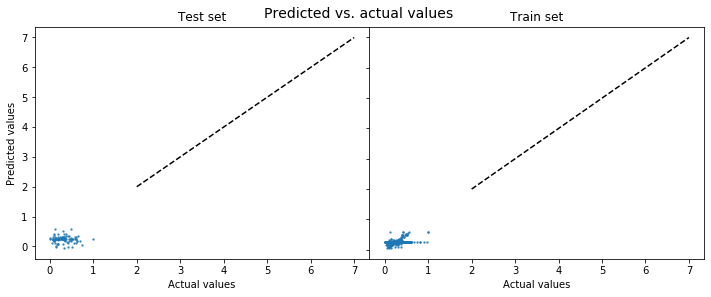

In [84]:
nn_model_evaluation(model, skip_epochs=0, X_train=X_train_new, X_test=X_test_new, y_train=y_train_new, y_test=y_test_new)